In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages io.delta:delta-core_2.12:1.2.0 pyspark-shell'
 
import findspark
findspark.init()

In [2]:
!tail -6 /opt/spark/conf/spark-defaults.conf

#---------------------
#       Delta Lake
#---------------------
#spark.jars.packages io.delta:delta-core_2.12:1.2.0  
#spark.sql.extensions io.delta.sql.DeltaSparkSessionExtension
#spark.sql.catalog.spark_catalog org.apache.spark.sql.delta.catalog.DeltaCatalog


In [3]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Delta seminar 2022") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .getOrCreate()

:: loading settings :: url = jar:file:/opt/spark-3.2.0-bin-hadoop3.2/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/lucasmsp/.ivy2/cache
The jars for the packages stored in: /home/lucasmsp/.ivy2/jars
io.delta#delta-core_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-54e90557-932c-47b8-9645-9b16e8160faa;1.0
	confs: [default]
	found io.delta#delta-core_2.12;1.2.0 in central
	found io.delta#delta-storage;1.2.0 in central
	found org.antlr#antlr4-runtime;4.8 in central
	found org.codehaus.jackson#jackson-core-asl;1.9.13 in central
:: resolution report :: resolve 200ms :: artifacts dl 10ms
	:: modules in use:
	io.delta#delta-core_2.12;1.2.0 from central in [default]
	io.delta#delta-storage;1.2.0 from central in [default]
	org.antlr#antlr4-runtime;4.8 from central in [default]
	org.codehaus.jackson#jackson-core-asl;1.9.13 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlde

In [4]:
from pyspark.sql.functions import expr, udf, col, lit
from pyspark.sql.types import *

from delta.tables import *

import datetime

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

spark.conf.set("spark.sql.shuffle.partitions", "1")

/tmp/ipykernel_3611834/3214146474.py:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


In [5]:
!rm -r /tmp/delta_tutorial/*

In [6]:
PARQUET_PATH="/tmp/delta_tutorial/parquet_table"
DELTA_PATH="/tmp/delta_tutorial/delta_table"

## 1. Data generation

In [7]:
raw_data = spark.range(100000) \
  .selectExpr("if(id % 2 = 0, 'Open', 'Close') as action") \
  .withColumn("date", expr("cast(concat('2021-04-', cast(rand(5) * 5 as int) + 1) as date)")) \
  .withColumn("device_id", expr("cast(rand(5) * 100 as int)"))

In [8]:
def pretty_show(df, n=5):
    display(df.limit(n).toPandas())
    
pretty_show(raw_data)

,action,date,device_id
0,Open,2021-04-01,2
1,Close,2021-04-01,9
2,Open,2021-04-04,77
3,Close,2021-04-03,54
4,Open,2021-04-02,33


## 2. Parquet

In [9]:
raw_data.repartition(1)\
    .write\
    .format("parquet")\
    .save(PARQUET_PATH)

In [10]:
!ls -lhR {PARQUET_PATH}

/tmp/delta_tutorial/parquet_table:
total 128K
-rw-r--r-- 1 lucasmsp lucasmsp 126K abr 25 11:16 part-00000-337586c5-2c1e-495d-8149-0643f5aaa3c8-c000.snappy.parquet
-rw-r--r-- 1 lucasmsp lucasmsp    0 abr 25 11:16 _SUCCESS


In [11]:
@udf
def gen_error(x):
    if x<=50:
        return "Closed" 
    else:
        raise Exception("Atomicity failed")

    
# spark.read.parquet(PARQUET_PATH)\
#     .withColumn('action', gen_error(col("device_id")))\
#     .write.parquet(PARQUET_PATH, mode="overwrite")

raw_data\
    .withColumn('action', gen_error(col("device_id")))\
    .repartition(1)\
    .write.format("parquet").mode("overwrite").save(PARQUET_PATH)

Py4JJavaError: An error occurred while calling o77.save.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.jobAbortedError(QueryExecutionErrors.scala:496)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:251)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:186)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:113)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:111)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:125)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:110)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:110)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:106)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:481)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:82)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:481)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:457)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:106)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:93)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:91)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:128)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:848)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:382)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:355)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:239)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 7 in stage 4.0 failed 1 times, most recent failure: Lost task 7.0 in stage 4.0 (TID 17) (192.168.0.209 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/tmp/ipykernel_3611834/3063536678.py", line 6, in gen_error
Exception: Atomicity failed

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:545)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:86)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:68)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:498)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2352)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2351)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2351)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1109)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1109)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1109)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2591)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2533)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2522)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/tmp/ipykernel_3611834/3063536678.py", line 6, in gen_error
Exception: Atomicity failed

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:545)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:86)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:68)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:498)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)


In [12]:
!ls -lhR {PARQUET_PATH}

/tmp/delta_tutorial/parquet_table:
total 0


## 3. Delta Lake

In [13]:
raw_data\
    .repartition(1)\
    .write\
    .format("delta")\
    .mode("overwrite")\
    .save(DELTA_PATH)

In [14]:
!ls -lhR {DELTA_PATH}

/tmp/delta_tutorial/delta_table:
total 132K
drwxr-xr-x 2 lucasmsp lucasmsp 4,0K abr 25 11:16 _delta_log
-rw-r--r-- 1 lucasmsp lucasmsp 126K abr 25 11:16 part-00000-45d36500-f9ba-4a4a-9cec-907d2a1ca41a-c000.snappy.parquet

/tmp/delta_tutorial/delta_table/_delta_log:
total 4,0K
-rw-r--r-- 1 lucasmsp lucasmsp 1,3K abr 25 11:16 00000000000000000000.json


In [15]:
!cat {DELTA_PATH}/_delta_log/00000000000000000000.json | jq

{
  "protocol": {
    "minReaderVersion": 1,
    "minWriterVersion": 2
  }
}
{
  "metaData": {
    "id": "33217047-13d2-4f2d-9160-f3d4daa2b57f",
    "format": {
      "provider": "parquet",
      "options": {}
    },
    "schemaString": "{\"type\":\"struct\",\"fields\":[{\"name\":\"action\",\"type\":\"string\",\"nullable\":true,\"metadata\":{}},{\"name\":\"date\",\"type\":\"date\",\"nullable\":true,\"metadata\":{}},{\"name\":\"device_id\",\"type\":\"integer\",\"nullable\":true,\"metadata\":{}}]}",
    "partitionColumns": [],
    "configuration": {},
    "createdTime": 1650896185016
  }
}
{
  "add": {
    "path": "part-00000-45d36500-f9ba-4a4a-9cec-907d2a1ca41a-c000.snappy.parquet",
    "partitionValues": {},
    "size": 128331,
    "modificationTime": 1650896185808,
    "dataChange": true,
    "stats": "{\"numRecords\":100000,\"minValues\":{\"action\":\"Close\",\"date\":\"2021-04-01\",\"device_id\":0},\"maxValues\":{\"action\":\"Open\",\"date\":\"2021-04-05\",\"device_id\":99},\"nullCo

In [16]:
raw_data\
    .withColumn('action', gen_error(col("device_id")))\
    .repartition(1)\
    .write.format("delta")\
    .mode("overwrite")\
    .save(DELTA_PATH)

Py4JJavaError: An error occurred while calling o98.save.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.jobAbortedError(QueryExecutionErrors.scala:496)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:251)
	at org.apache.spark.sql.delta.files.TransactionalWrite.$anonfun$writeFiles$3(TransactionalWrite.scala:312)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.delta.files.TransactionalWrite.writeFiles(TransactionalWrite.scala:278)
	at org.apache.spark.sql.delta.files.TransactionalWrite.writeFiles$(TransactionalWrite.scala:223)
	at org.apache.spark.sql.delta.OptimisticTransaction.writeFiles(OptimisticTransaction.scala:98)
	at org.apache.spark.sql.delta.files.TransactionalWrite.writeFiles(TransactionalWrite.scala:206)
	at org.apache.spark.sql.delta.files.TransactionalWrite.writeFiles$(TransactionalWrite.scala:202)
	at org.apache.spark.sql.delta.OptimisticTransaction.writeFiles(OptimisticTransaction.scala:98)
	at org.apache.spark.sql.delta.files.TransactionalWrite.writeFiles(TransactionalWrite.scala:212)
	at org.apache.spark.sql.delta.files.TransactionalWrite.writeFiles$(TransactionalWrite.scala:209)
	at org.apache.spark.sql.delta.OptimisticTransaction.writeFiles(OptimisticTransaction.scala:98)
	at org.apache.spark.sql.delta.commands.WriteIntoDelta.write(WriteIntoDelta.scala:181)
	at org.apache.spark.sql.delta.commands.WriteIntoDelta.$anonfun$run$1(WriteIntoDelta.scala:80)
	at org.apache.spark.sql.delta.commands.WriteIntoDelta.$anonfun$run$1$adapted(WriteIntoDelta.scala:78)
	at org.apache.spark.sql.delta.DeltaLog.withNewTransaction(DeltaLog.scala:212)
	at org.apache.spark.sql.delta.commands.WriteIntoDelta.run(WriteIntoDelta.scala:78)
	at org.apache.spark.sql.delta.sources.DeltaDataSource.createRelation(DeltaDataSource.scala:156)
	at org.apache.spark.sql.execution.datasources.SaveIntoDataSourceCommand.run(SaveIntoDataSourceCommand.scala:45)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:75)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:73)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.executeCollect(commands.scala:84)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:110)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:110)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:106)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:481)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:82)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:481)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:457)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:106)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:93)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:91)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:128)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:848)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:382)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:303)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:239)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 7 in stage 14.0 failed 1 times, most recent failure: Lost task 7.0 in stage 14.0 (TID 86) (192.168.0.209 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/tmp/ipykernel_3611834/3063536678.py", line 6, in gen_error
Exception: Atomicity failed

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:545)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:86)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:68)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:498)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2352)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2351)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2351)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1109)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1109)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1109)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2591)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2533)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2522)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/tmp/ipykernel_3611834/3063536678.py", line 6, in gen_error
Exception: Atomicity failed

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:545)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:86)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:68)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:498)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)


In [17]:
!ls -lhR {DELTA_PATH}

/tmp/delta_tutorial/delta_table:
total 132K
drwxr-xr-x 2 lucasmsp lucasmsp 4,0K abr 25 11:16 _delta_log
-rw-r--r-- 1 lucasmsp lucasmsp 126K abr 25 11:16 part-00000-45d36500-f9ba-4a4a-9cec-907d2a1ca41a-c000.snappy.parquet

/tmp/delta_tutorial/delta_table/_delta_log:
total 4,0K
-rw-r--r-- 1 lucasmsp lucasmsp 1,3K abr 25 11:16 00000000000000000000.json


In [18]:
df = spark.read.format("delta").load(DELTA_PATH)

pretty_show(df)

,action,date,device_id
0,Open,2021-04-01,2
1,Close,2021-04-01,9
2,Open,2021-04-04,77
3,Close,2021-04-03,54
4,Open,2021-04-02,33


### 3.1. Schema Enforcement and Evolution

Delta Lake provides the ability to specify your schema and enforce it. This helps ensure that the data types are correct and required columns are present, preventing bad data from causing data corruption.

- All DataFrame columns must exist in the target table. If there are columns in the DataFrame not present in the table, an exception is raised. Columns present in the table but not in the DataFrame are set to null.
- DataFrame column data types must match the column data types in the target table. If they don’t match, an exception is raised.
- If you specify other options, such as partitionBy, in combination with append mode, Delta Lake validates that they match and throws an error for any mismatch. When partitionBy is not present, appends automatically follow the partitioning of the existing data.

In [19]:
new_data_with_new_col = spark.range(1000) \
  .selectExpr("'Open' as action","cast(concat('2021-04-', cast(rand(5) * 3 as int) + 1) as date) as date") \
  .withColumn("device_id", expr("cast(rand(5) * 100 as int)")) \
  .withColumn("user_id", expr("cast(rand(10) * 100 as int)"))
  
new_data_with_new_col.repartition(1).write.format("delta").mode("append").save(DELTA_PATH)

AnalysisException: A schema mismatch detected when writing to the Delta table (Table ID: 33217047-13d2-4f2d-9160-f3d4daa2b57f).
To enable schema migration using DataFrameWriter or DataStreamWriter, please set:
'.option("mergeSchema", "true")'.
For other operations, set the session configuration
spark.databricks.delta.schema.autoMerge.enabled to "true". See the documentation
specific to the operation for details.

Table schema:
root
-- action: string (nullable = true)
-- date: date (nullable = true)
-- device_id: integer (nullable = true)


Data schema:
root
-- action: string (nullable = true)
-- date: date (nullable = true)
-- device_id: integer (nullable = true)
-- user_id: integer (nullable = true)

         

In [20]:
new_data_with_new_col.repartition(1)\
    .write\
    .format("delta")\
    .option("mergeSchema", "true")\
    .mode("append").save(DELTA_PATH)

In [21]:
spark.read.format("delta").load(DELTA_PATH).printSchema()

root
 |-- action: string (nullable = true)
 |-- date: date (nullable = true)
 |-- device_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)



In [22]:
!ls -lhR {DELTA_PATH}/_delta_log

/tmp/delta_tutorial/delta_table/_delta_log:
total 8,0K
-rw-r--r-- 1 lucasmsp lucasmsp 1,3K abr 25 11:16 00000000000000000000.json
-rw-r--r-- 1 lucasmsp lucasmsp 1,4K abr 25 11:16 00000000000000000001.json


### 3.2. Audit History and Time travel

Delta Lake transaction log records details about every change made to data providing a full audit trail of the changes. 

- You can audit data in your Data Lake.
    - Retrieve information on the operations, user, timestamp, and so on for each write to a Delta table by running the history command. 
- You can roll back data in your Data Lake in case of bad writes and deletes.
- Time travel helps to re-create analysis and reports based on older versions of data.
- You can do time-series analytics.


#### History Table

| Column              | Type      | Description                                                               |
|---------------------|-----------|---------------------------------------------------------------------------|
| version             | long      | Table version generated by the operation.                                 |
| timestamp           | timestamp | When this version was committed.                                          |
| ...                 | ...       | ...                                                                       |
| operation           | string    | Name of the operation.                                                    |
| operationParameters | map       | Parameters of the operation (for example, predicates.)                    |
| operationMetrics    | map       | Metrics of the operation (for example, number of rows and files modified. |

In [23]:
def get_history():
    deltaTable = DeltaTable.forPath(spark, DELTA_PATH)
    h = deltaTable.history().toPandas()[["version", "timestamp", "operation", 
                                        "operationParameters",  "operationMetrics"]]
    display(h)
    

get_history()

,version,timestamp,operation,operationParameters,operationMetrics
0,1,2022-04-25 11:16:53.757,WRITE,"{'mode': 'Append', 'partitionBy': '[]'}","{'numOutputRows': '1000', 'numOutputBytes': '4160', 'numFiles': '1'}"
1,0,2022-04-25 11:16:27.300,WRITE,"{'mode': 'Overwrite', 'partitionBy': '[]'}","{'numOutputRows': '100000', 'numOutputBytes': '128331', 'numFiles': '1'}"


In [24]:
df = spark.read.format("delta").load(DELTA_PATH)
df.count()

101000

In [25]:
tmp = df.filter(col("user_id").isNotNull())
pretty_show(tmp)

,action,date,device_id,user_id
0,Open,2021-04-01,2,17
1,Open,2021-04-01,9,80
2,Open,2021-04-03,77,57
3,Open,2021-04-02,54,94
4,Open,2021-04-02,33,20


In [26]:
tmp = (
 spark.read.format("delta")
      .option("versionAsOf", 0)
      .load(DELTA_PATH)
)

# By timestamp: option("timestampAsOf", "2022-04-11 13:10:58.729")

pretty_show(tmp)

,action,date,device_id
0,Open,2021-04-01,2
1,Close,2021-04-01,9
2,Open,2021-04-04,77
3,Close,2021-04-03,54
4,Open,2021-04-02,33


### 3.3.  Delete

In [27]:
df = spark.read.format("delta").load(DELTA_PATH)
df.registerTempTable("delta")

df.count()

/opt/spark/python/pyspark/sql/dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(


101000

In [28]:
df.filter("user_id=1").count()

8

In [29]:
spark.sql("DELETE FROM delta WHERE user_id = 1")

# Python API: deltaTable.delete(col("user_id") == 1)

DataFrame[]

In [30]:
df.count()

100992

#### Delete - under the hood

- Updates data at the granularity of **files**:

    - Scan 1: Find and select which files contain data matching predicate

    - Scan 2: Read the selected files and rewrite them as new files without the matching records


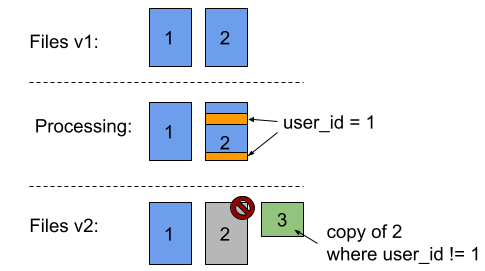

In [31]:
get_history()

,version,timestamp,operation,operationParameters,operationMetrics
0,2,2022-04-25 11:17:00.325,DELETE,"{'predicate': '[""(delta.user_id = 1)""]'}","{'numAddedFiles': '1', 'scanTimeMs': '527', 'numCopiedRows': '992', 'executionTimeMs': '693', 'numDeletedRows': '8', 'numRemovedFiles': '1', 'rewriteTimeMs': '165'}"
1,1,2022-04-25 11:16:53.757,WRITE,"{'mode': 'Append', 'partitionBy': '[]'}","{'numOutputRows': '1000', 'numOutputBytes': '4160', 'numFiles': '1'}"
2,0,2022-04-25 11:16:27.300,WRITE,"{'mode': 'Overwrite', 'partitionBy': '[]'}","{'numOutputRows': '100000', 'numOutputBytes': '128331', 'numFiles': '1'}"


#### Recovering delete records by time travel (Old version)

In [32]:
old = spark.read.format("delta")\
    .option("versionAsOf", 1)\
    .load(DELTA_PATH)\
    .filter(col("user_id") == 1)

old.repartition(1)\
    .write\
    .format("delta")\
    .mode("append").save(DELTA_PATH)

In [33]:
get_history()

,version,timestamp,operation,operationParameters,operationMetrics
0,3,2022-04-25 11:17:03.285,WRITE,"{'mode': 'Append', 'partitionBy': '[]'}","{'numOutputRows': '8', 'numOutputBytes': '1312', 'numFiles': '1'}"
1,2,2022-04-25 11:17:00.325,DELETE,"{'predicate': '[""(delta.user_id = 1)""]'}","{'numAddedFiles': '1', 'scanTimeMs': '527', 'numCopiedRows': '992', 'executionTimeMs': '693', 'numDeletedRows': '8', 'numRemovedFiles': '1', 'rewriteTimeMs': '165'}"
2,1,2022-04-25 11:16:53.757,WRITE,"{'mode': 'Append', 'partitionBy': '[]'}","{'numOutputRows': '1000', 'numOutputBytes': '4160', 'numFiles': '1'}"
3,0,2022-04-25 11:16:27.300,WRITE,"{'mode': 'Overwrite', 'partitionBy': '[]'}","{'numOutputRows': '100000', 'numOutputBytes': '128331', 'numFiles': '1'}"


In [34]:
df.count()

101000

#### Recovering delete records by time travel (Starting from v1.2)

In [35]:
deltaTable = DeltaTable.forPath(spark, DELTA_PATH)
deltaTable.restoreToVersion(2)

DataFrame[table_size_after_restore: bigint, num_of_files_after_restore: bigint, num_removed_files: bigint, num_restored_files: bigint, removed_files_size: bigint, restored_files_size: bigint]

In [36]:
get_history()

,version,timestamp,operation,operationParameters,operationMetrics
0,4,2022-04-25 11:17:09.049,RESTORE,"{'version': '2', 'timestamp': None}","{'removedFilesSize': '1312', 'tableSizeAfterRestore': '132472', 'numRemovedFiles': '1', 'restoredFilesSize': '0', 'numOfFilesAfterRestore': '2', 'numRestoredFiles': '0'}"
1,3,2022-04-25 11:17:03.285,WRITE,"{'mode': 'Append', 'partitionBy': '[]'}","{'numOutputRows': '8', 'numOutputBytes': '1312', 'numFiles': '1'}"
2,2,2022-04-25 11:17:00.325,DELETE,"{'predicate': '[""(delta.user_id = 1)""]'}","{'numAddedFiles': '1', 'scanTimeMs': '527', 'numCopiedRows': '992', 'executionTimeMs': '693', 'numDeletedRows': '8', 'numRemovedFiles': '1', 'rewriteTimeMs': '165'}"
3,1,2022-04-25 11:16:53.757,WRITE,"{'mode': 'Append', 'partitionBy': '[]'}","{'numOutputRows': '1000', 'numOutputBytes': '4160', 'numFiles': '1'}"
4,0,2022-04-25 11:16:27.300,WRITE,"{'mode': 'Overwrite', 'partitionBy': '[]'}","{'numOutputRows': '100000', 'numOutputBytes': '128331', 'numFiles': '1'}"


In [37]:
df.count()

100992

### 3.4. Merge 

#### Update

In [38]:
updates = spark.read.format("delta")\
    .load(DELTA_PATH)\
    .filter(col("user_id") == 3)\
    .withColumn("device_id", lit(-3))\
    .withColumnRenamed("user_id", "id")\
    .drop("action")\
    .dropDuplicates()
    
pretty_show(updates)

,date,device_id,id
0,2021-04-03,-3,3
1,2021-04-02,-3,3
2,2021-04-01,-3,3


In [39]:
"""
    MERGE INTO old
    USING updates
    ON old.user_id = updates.id AND old.date = updates.date
    WHEN MATCHED THEN
      UPDATE SET old.device_id = updates.device_id
"""

deltaTable = DeltaTable.forPath(spark, DELTA_PATH)

deltaTable.alias("old")\
    .merge(updates.alias("updates"), "old.user_id = updates.id AND old.date = updates.date") \
      .whenMatchedUpdate(set={ "old.device_id" : "updates.device_id" } ) \
      .execute()

[MergeBuilder](https://docs.delta.io/0.4.0/api/python/index.html#delta.tables.DeltaMergeBuilder) clauses:
 - whenMatchedUpdate(condition=None, set=None)
 - whenMatchedUpdateAll(condition=None)
 - whenMatchedDelete(condition=None)
 - whenNotMatchedInsert(condition=None, values=None)
 - whenNotMatchedInsertAll(condition=None)

In [40]:
tmp = spark.read.format("delta")\
    .load(DELTA_PATH)\
    .filter(col("user_id") == 3)

pretty_show(tmp)

,action,date,device_id,user_id
0,Open,2021-04-03,-3,3
1,Open,2021-04-03,-3,3
2,Open,2021-04-03,-3,3
3,Open,2021-04-02,-3,3
4,Open,2021-04-02,-3,3


In [41]:
get_history()

,version,timestamp,operation,operationParameters,operationMetrics
0,5,2022-04-25 11:17:12.601,MERGE,"{'matchedPredicates': '[{""actionType"":""update""}]', 'predicate': '((old.user_id = updates.id) AND (old.date = updates.date))', 'notMatchedPredicates': '[]'}","{'numOutputRows': '992', 'numTargetRowsInserted': '0', 'numTargetRowsUpdated': '11', 'numTargetFilesAdded': '1', 'numTargetFilesRemoved': '1', 'numTargetRowsDeleted': '0', 'scanTimeMs': '767', 'numSourceRows': '3', 'executionTimeMs': '1534', 'numTargetRowsCopied': '981', 'rewriteTimeMs': '763'}"
1,4,2022-04-25 11:17:09.049,RESTORE,"{'version': '2', 'timestamp': None}","{'removedFilesSize': '1312', 'tableSizeAfterRestore': '132472', 'numRemovedFiles': '1', 'restoredFilesSize': '0', 'numOfFilesAfterRestore': '2', 'numRestoredFiles': '0'}"
2,3,2022-04-25 11:17:03.285,WRITE,"{'mode': 'Append', 'partitionBy': '[]'}","{'numOutputRows': '8', 'numOutputBytes': '1312', 'numFiles': '1'}"
3,2,2022-04-25 11:17:00.325,DELETE,"{'predicate': '[""(delta.user_id = 1)""]'}","{'numAddedFiles': '1', 'scanTimeMs': '527', 'numCopiedRows': '992', 'executionTimeMs': '693', 'numDeletedRows': '8', 'numRemovedFiles': '1', 'rewriteTimeMs': '165'}"
4,1,2022-04-25 11:16:53.757,WRITE,"{'mode': 'Append', 'partitionBy': '[]'}","{'numOutputRows': '1000', 'numOutputBytes': '4160', 'numFiles': '1'}"
5,0,2022-04-25 11:16:27.300,WRITE,"{'mode': 'Overwrite', 'partitionBy': '[]'}","{'numOutputRows': '100000', 'numOutputBytes': '128331', 'numFiles': '1'}"


#### Upsert

In [42]:
upsert = spark.createDataFrame(
        pd.DataFrame([
            ['Closed', datetime.date(2021, 4, 1), 3, 3],
            ['Closed', datetime.date(2021, 4, 4), 3, 3]], 
            columns=["action", "date", "user_id", "device_id"])
)

pretty_show(upsert)

,action,date,user_id,device_id
0,Closed,2021-04-01,3,3
1,Closed,2021-04-04,3,3


In [43]:
deltaTable = DeltaTable.forPath(spark, DELTA_PATH)

deltaTable.alias("old")\
    .merge(
        upsert.alias("upsert"),
        "old.user_id = upsert.user_id AND old.date = upsert.date")\
    .whenMatchedUpdateAll()\
    .whenNotMatchedInsertAll()\
    .execute()

In [44]:
tmp = spark.read.format("delta")\
    .load(DELTA_PATH)\
    .filter((col("user_id") == 3) & (col("date").isin([datetime.date(2021, 4, 1), datetime.date(2021, 4, 4)])))

pretty_show(tmp, 5)

,action,date,device_id,user_id
0,Closed,2021-04-01,3,3
1,Closed,2021-04-04,3,3


In [45]:
get_history()

,version,timestamp,operation,operationParameters,operationMetrics
0,6,2022-04-25 11:17:16.353,MERGE,"{'matchedPredicates': '[{""actionType"":""update""}]', 'predicate': '((CAST(old.user_id AS BIGINT) = upsert.user_id) AND (old.date = upsert.date))', 'notMatchedPredicates': '[{""actionType"":""insert""}]'}","{'numOutputRows': '993', 'numTargetRowsInserted': '1', 'numTargetRowsUpdated': '1', 'numTargetFilesAdded': '1', 'numTargetFilesRemoved': '1', 'numTargetRowsDeleted': '0', 'scanTimeMs': '476', 'numSourceRows': '2', 'executionTimeMs': '954', 'numTargetRowsCopied': '991', 'rewriteTimeMs': '476'}"
1,5,2022-04-25 11:17:12.601,MERGE,"{'matchedPredicates': '[{""actionType"":""update""}]', 'predicate': '((old.user_id = updates.id) AND (old.date = updates.date))', 'notMatchedPredicates': '[]'}","{'numOutputRows': '992', 'numTargetRowsInserted': '0', 'numTargetRowsUpdated': '11', 'numTargetFilesAdded': '1', 'numTargetFilesRemoved': '1', 'numTargetRowsDeleted': '0', 'scanTimeMs': '767', 'numSourceRows': '3', 'executionTimeMs': '1534', 'numTargetRowsCopied': '981', 'rewriteTimeMs': '763'}"
2,4,2022-04-25 11:17:09.049,RESTORE,"{'version': '2', 'timestamp': None}","{'removedFilesSize': '1312', 'tableSizeAfterRestore': '132472', 'numRemovedFiles': '1', 'restoredFilesSize': '0', 'numOfFilesAfterRestore': '2', 'numRestoredFiles': '0'}"
3,3,2022-04-25 11:17:03.285,WRITE,"{'mode': 'Append', 'partitionBy': '[]'}","{'numOutputRows': '8', 'numOutputBytes': '1312', 'numFiles': '1'}"
4,2,2022-04-25 11:17:00.325,DELETE,"{'predicate': '[""(delta.user_id = 1)""]'}","{'numAddedFiles': '1', 'scanTimeMs': '527', 'numCopiedRows': '992', 'executionTimeMs': '693', 'numDeletedRows': '8', 'numRemovedFiles': '1', 'rewriteTimeMs': '165'}"
5,1,2022-04-25 11:16:53.757,WRITE,"{'mode': 'Append', 'partitionBy': '[]'}","{'numOutputRows': '1000', 'numOutputBytes': '4160', 'numFiles': '1'}"
6,0,2022-04-25 11:16:27.300,WRITE,"{'mode': 'Overwrite', 'partitionBy': '[]'}","{'numOutputRows': '100000', 'numOutputBytes': '128331', 'numFiles': '1'}"


### 3.5.  Table optimization: Checkpoints (on metadata) and Compact files (on data)

Table optimization is an operation to reorganize data and/or metadata to speed up queries and/or reduce metadata.

#### Checkpoints

Every **10 commit** files are being aggregated to a checkpoint file of type parquet.  It allows the Spark engine to avoid reprocessing thousands of tiny JSON files. 

In [46]:
deltaTable.update(col("user_id") == "4", { "action": lit("Closed") } ) 
deltaTable.update(col("user_id") == "5", { "action": lit("Closed") } ) 
deltaTable.update(col("user_id") == "6", { "action": lit("Closed") } ) 
deltaTable.update(col("user_id") == "7", { "action": lit("Closed") } ) 
deltaTable.update(col("user_id") == "8", { "action": lit("Closed") } ) 
deltaTable.update(col("user_id") == "9", { "action": lit("Closed") } )

In [47]:
!ls -lhR {DELTA_PATH}

/tmp/delta_tutorial/delta_table:
total 188K
drwxr-xr-x 2 lucasmsp lucasmsp 4,0K abr 25 11:17 _delta_log
-rw-r--r-- 1 lucasmsp lucasmsp 3,6K abr 25 11:17 part-00000-0668e7ff-911b-451d-ba5d-c771857082ea-c000.snappy.parquet
-rw-r--r-- 1 lucasmsp lucasmsp 3,6K abr 25 11:17 part-00000-07bb28b4-6676-443b-ab37-272f57ccc04d-c000.snappy.parquet
-rw-r--r-- 1 lucasmsp lucasmsp 4,1K abr 25 11:17 part-00000-2040e097-3e43-4e20-bc2a-3ec962cdfa20-c000.snappy.parquet
-rw-r--r-- 1 lucasmsp lucasmsp 4,1K abr 25 11:16 part-00000-2b70b7a7-690f-4034-86fe-cb23bb350a1d-c000.snappy.parquet
-rw-r--r-- 1 lucasmsp lucasmsp 3,6K abr 25 11:17 part-00000-2cad6cdc-1095-4f60-87ab-b29792d3d11d-c000.snappy.parquet
-rw-r--r-- 1 lucasmsp lucasmsp 126K abr 25 11:16 part-00000-45d36500-f9ba-4a4a-9cec-907d2a1ca41a-c000.snappy.parquet
-rw-r--r-- 1 lucasmsp lucasmsp 3,6K abr 25 11:17 part-00000-6ea2097a-33ff-483b-b995-de10852268e2-c000.snappy.parquet
-rw-r--r-- 1 lucasmsp lucasmsp 3,6K abr 25 11:17 part-00000-75bdd755-49e0-40b

#### Compacting files (starting from 1.2)

Reduce multiple small files into larger big files. 

In [48]:
spark.sql(f"OPTIMIZE '{DELTA_PATH}'").show(truncate=False)

+------------------------------------+----------------------------------------------------------------------------------------------------------+
|path                                |metrics                                                                                                   |
+------------------------------------+----------------------------------------------------------------------------------------------------------+
|file:/tmp/delta_tutorial/delta_table|{1, 2, {130965, 130965, 130965.0, 1, 130965}, {3669, 128331, 66000.0, 2, 132000}, 1, null, 1, 2, 0, false}|
+------------------------------------+----------------------------------------------------------------------------------------------------------+



In [49]:
get_history()

,version,timestamp,operation,operationParameters,operationMetrics
0,13,2022-04-25 11:17:28.193,OPTIMIZE,"{'predicate': '[""true""]'}","{'numRemovedBytes': '132000', 'p50FileSize': '130965', 'p25FileSize': '130965', 'numAddedFiles': '1', 'minFileSize': '130965', 'p75FileSize': '130965', 'numAddedBytes': '130965', 'maxFileSize': '130965', 'numRemovedFiles': '2'}"
1,12,2022-04-25 11:17:26.529,UPDATE,{'predicate': '(user_id#7300 = 9)'},"{'numAddedFiles': '1', 'scanTimeMs': '461', 'numCopiedRows': '978', 'executionTimeMs': '584', 'numUpdatedRows': '15', 'numRemovedFiles': '1', 'rewriteTimeMs': '123'}"
2,11,2022-04-25 11:17:25.157,UPDATE,{'predicate': '(user_id#7300 = 8)'},"{'numAddedFiles': '1', 'scanTimeMs': '429', 'numCopiedRows': '982', 'executionTimeMs': '559', 'numUpdatedRows': '11', 'numRemovedFiles': '1', 'rewriteTimeMs': '130'}"
3,10,2022-04-25 11:17:23.417,UPDATE,{'predicate': '(user_id#7300 = 7)'},"{'numAddedFiles': '1', 'scanTimeMs': '464', 'numCopiedRows': '982', 'executionTimeMs': '615', 'numUpdatedRows': '11', 'numRemovedFiles': '1', 'rewriteTimeMs': '151'}"
4,9,2022-04-25 11:17:22.013,UPDATE,{'predicate': '(user_id#7300 = 6)'},"{'numAddedFiles': '1', 'scanTimeMs': '488', 'numCopiedRows': '988', 'executionTimeMs': '616', 'numUpdatedRows': '5', 'numRemovedFiles': '1', 'rewriteTimeMs': '128'}"
5,8,2022-04-25 11:17:20.437,UPDATE,{'predicate': '(user_id#7300 = 5)'},"{'numAddedFiles': '1', 'scanTimeMs': '529', 'numCopiedRows': '976', 'executionTimeMs': '669', 'numUpdatedRows': '17', 'numRemovedFiles': '1', 'rewriteTimeMs': '140'}"
6,7,2022-04-25 11:17:18.545,UPDATE,{'predicate': '(user_id#7300 = 4)'},"{'numAddedFiles': '1', 'scanTimeMs': '274', 'numCopiedRows': '978', 'executionTimeMs': '416', 'numUpdatedRows': '15', 'numRemovedFiles': '1', 'rewriteTimeMs': '142'}"
7,6,2022-04-25 11:17:16.353,MERGE,"{'matchedPredicates': '[{""actionType"":""update""}]', 'predicate': '((CAST(old.user_id AS BIGINT) = upsert.user_id) AND (old.date = upsert.date))', 'notMatchedPredicates': '[{""actionType"":""insert""}]'}","{'numOutputRows': '993', 'numTargetRowsInserted': '1', 'numTargetRowsUpdated': '1', 'numTargetFilesAdded': '1', 'numTargetFilesRemoved': '1', 'numTargetRowsDeleted': '0', 'scanTimeMs': '476', 'numSourceRows': '2', 'executionTimeMs': '954', 'numTargetRowsCopied': '991', 'rewriteTimeMs': '476'}"
8,5,2022-04-25 11:17:12.601,MERGE,"{'matchedPredicates': '[{""actionType"":""update""}]', 'predicate': '((old.user_id = updates.id) AND (old.date = updates.date))', 'notMatchedPredicates': '[]'}","{'numOutputRows': '992', 'numTargetRowsInserted': '0', 'numTargetRowsUpdated': '11', 'numTargetFilesAdded': '1', 'numTargetFilesRemoved': '1', 'numTargetRowsDeleted': '0', 'scanTimeMs': '767', 'numSourceRows': '3', 'executionTimeMs': '1534', 'numTargetRowsCopied': '981', 'rewriteTimeMs': '763'}"
9,4,2022-04-25 11:17:09.049,RESTORE,"{'version': '2', 'timestamp': None}","{'removedFilesSize': '1312', 'tableSizeAfterRestore': '132472', 'numRemovedFiles': '1', 'restoredFilesSize': '0', 'numOfFilesAfterRestore': '2', 'numRestoredFiles': '0'}"


#### Compact files (Old way)

 - `option("dataChange", "false")` indicates that the operation did not change the data, only rearranges the layout;
 - `option("replaceWhere", partition)` can be used in partitioned data to avoid compact all data at once;

In [50]:
spark.read\
 .format("delta")\
 .load(DELTA_PATH)\
 .repartition(1)\
 .write\
 .option("dataChange", "false")\
 .format("delta")\
 .mode("overwrite")\
 .save(DELTA_PATH)

In [51]:
get_history()

,version,timestamp,operation,operationParameters,operationMetrics
0,14,2022-04-25 11:17:29.997,WRITE,"{'mode': 'Overwrite', 'partitionBy': '[]'}","{'numOutputRows': '100993', 'numOutputBytes': '130965', 'numFiles': '1'}"
1,13,2022-04-25 11:17:28.193,OPTIMIZE,"{'predicate': '[""true""]'}","{'numRemovedBytes': '132000', 'p50FileSize': '130965', 'p25FileSize': '130965', 'numAddedFiles': '1', 'minFileSize': '130965', 'p75FileSize': '130965', 'numAddedBytes': '130965', 'maxFileSize': '130965', 'numRemovedFiles': '2'}"
2,12,2022-04-25 11:17:26.529,UPDATE,{'predicate': '(user_id#7300 = 9)'},"{'numAddedFiles': '1', 'scanTimeMs': '461', 'numCopiedRows': '978', 'executionTimeMs': '584', 'numUpdatedRows': '15', 'numRemovedFiles': '1', 'rewriteTimeMs': '123'}"
3,11,2022-04-25 11:17:25.157,UPDATE,{'predicate': '(user_id#7300 = 8)'},"{'numAddedFiles': '1', 'scanTimeMs': '429', 'numCopiedRows': '982', 'executionTimeMs': '559', 'numUpdatedRows': '11', 'numRemovedFiles': '1', 'rewriteTimeMs': '130'}"
4,10,2022-04-25 11:17:23.417,UPDATE,{'predicate': '(user_id#7300 = 7)'},"{'numAddedFiles': '1', 'scanTimeMs': '464', 'numCopiedRows': '982', 'executionTimeMs': '615', 'numUpdatedRows': '11', 'numRemovedFiles': '1', 'rewriteTimeMs': '151'}"
5,9,2022-04-25 11:17:22.013,UPDATE,{'predicate': '(user_id#7300 = 6)'},"{'numAddedFiles': '1', 'scanTimeMs': '488', 'numCopiedRows': '988', 'executionTimeMs': '616', 'numUpdatedRows': '5', 'numRemovedFiles': '1', 'rewriteTimeMs': '128'}"
6,8,2022-04-25 11:17:20.437,UPDATE,{'predicate': '(user_id#7300 = 5)'},"{'numAddedFiles': '1', 'scanTimeMs': '529', 'numCopiedRows': '976', 'executionTimeMs': '669', 'numUpdatedRows': '17', 'numRemovedFiles': '1', 'rewriteTimeMs': '140'}"
7,7,2022-04-25 11:17:18.545,UPDATE,{'predicate': '(user_id#7300 = 4)'},"{'numAddedFiles': '1', 'scanTimeMs': '274', 'numCopiedRows': '978', 'executionTimeMs': '416', 'numUpdatedRows': '15', 'numRemovedFiles': '1', 'rewriteTimeMs': '142'}"
8,6,2022-04-25 11:17:16.353,MERGE,"{'matchedPredicates': '[{""actionType"":""update""}]', 'predicate': '((CAST(old.user_id AS BIGINT) = upsert.user_id) AND (old.date = upsert.date))', 'notMatchedPredicates': '[{""actionType"":""insert""}]'}","{'numOutputRows': '993', 'numTargetRowsInserted': '1', 'numTargetRowsUpdated': '1', 'numTargetFilesAdded': '1', 'numTargetFilesRemoved': '1', 'numTargetRowsDeleted': '0', 'scanTimeMs': '476', 'numSourceRows': '2', 'executionTimeMs': '954', 'numTargetRowsCopied': '991', 'rewriteTimeMs': '476'}"
9,5,2022-04-25 11:17:12.601,MERGE,"{'matchedPredicates': '[{""actionType"":""update""}]', 'predicate': '((old.user_id = updates.id) AND (old.date = updates.date))', 'notMatchedPredicates': '[]'}","{'numOutputRows': '992', 'numTargetRowsInserted': '0', 'numTargetRowsUpdated': '11', 'numTargetFilesAdded': '1', 'numTargetFilesRemoved': '1', 'numTargetRowsDeleted': '0', 'scanTimeMs': '767', 'numSourceRows': '3', 'executionTimeMs': '1534', 'numTargetRowsCopied': '981', 'rewriteTimeMs': '763'}"


#### Data Vacuum

Delete files not required by **versions** older than the default 7 days retention period.

**Caution**: Do not run vacuum 0 when others writes are in progress 

In [52]:
!ls -lhR {DELTA_PATH}/*.parquet | wc -l

14


In [53]:
spark.sql("SET spark.databricks.delta.retentionDurationCheck.enabled=false")


deltaTable = DeltaTable.forPath(spark, DELTA_PATH)
deltaTable.vacuum(0.0001)

## Spark SQL: spark.sql("VACUUM <TABLE_NAME> [RETAIN HOURS]")

Deleted 13 files and directories in a total of 1 directories.


DataFrame[]

In [54]:
get_history()

,version,timestamp,operation,operationParameters,operationMetrics
0,14,2022-04-25 11:17:29.997,WRITE,"{'mode': 'Overwrite', 'partitionBy': '[]'}","{'numOutputRows': '100993', 'numOutputBytes': '130965', 'numFiles': '1'}"
1,13,2022-04-25 11:17:28.193,OPTIMIZE,"{'predicate': '[""true""]'}","{'numRemovedBytes': '132000', 'p50FileSize': '130965', 'p25FileSize': '130965', 'numAddedFiles': '1', 'minFileSize': '130965', 'p75FileSize': '130965', 'numAddedBytes': '130965', 'maxFileSize': '130965', 'numRemovedFiles': '2'}"
2,12,2022-04-25 11:17:26.529,UPDATE,{'predicate': '(user_id#7300 = 9)'},"{'numAddedFiles': '1', 'scanTimeMs': '461', 'numCopiedRows': '978', 'executionTimeMs': '584', 'numUpdatedRows': '15', 'numRemovedFiles': '1', 'rewriteTimeMs': '123'}"
3,11,2022-04-25 11:17:25.157,UPDATE,{'predicate': '(user_id#7300 = 8)'},"{'numAddedFiles': '1', 'scanTimeMs': '429', 'numCopiedRows': '982', 'executionTimeMs': '559', 'numUpdatedRows': '11', 'numRemovedFiles': '1', 'rewriteTimeMs': '130'}"
4,10,2022-04-25 11:17:23.417,UPDATE,{'predicate': '(user_id#7300 = 7)'},"{'numAddedFiles': '1', 'scanTimeMs': '464', 'numCopiedRows': '982', 'executionTimeMs': '615', 'numUpdatedRows': '11', 'numRemovedFiles': '1', 'rewriteTimeMs': '151'}"
5,9,2022-04-25 11:17:22.013,UPDATE,{'predicate': '(user_id#7300 = 6)'},"{'numAddedFiles': '1', 'scanTimeMs': '488', 'numCopiedRows': '988', 'executionTimeMs': '616', 'numUpdatedRows': '5', 'numRemovedFiles': '1', 'rewriteTimeMs': '128'}"
6,8,2022-04-25 11:17:20.437,UPDATE,{'predicate': '(user_id#7300 = 5)'},"{'numAddedFiles': '1', 'scanTimeMs': '529', 'numCopiedRows': '976', 'executionTimeMs': '669', 'numUpdatedRows': '17', 'numRemovedFiles': '1', 'rewriteTimeMs': '140'}"
7,7,2022-04-25 11:17:18.545,UPDATE,{'predicate': '(user_id#7300 = 4)'},"{'numAddedFiles': '1', 'scanTimeMs': '274', 'numCopiedRows': '978', 'executionTimeMs': '416', 'numUpdatedRows': '15', 'numRemovedFiles': '1', 'rewriteTimeMs': '142'}"
8,6,2022-04-25 11:17:16.353,MERGE,"{'matchedPredicates': '[{""actionType"":""update""}]', 'predicate': '((CAST(old.user_id AS BIGINT) = upsert.user_id) AND (old.date = upsert.date))', 'notMatchedPredicates': '[{""actionType"":""insert""}]'}","{'numOutputRows': '993', 'numTargetRowsInserted': '1', 'numTargetRowsUpdated': '1', 'numTargetFilesAdded': '1', 'numTargetFilesRemoved': '1', 'numTargetRowsDeleted': '0', 'scanTimeMs': '476', 'numSourceRows': '2', 'executionTimeMs': '954', 'numTargetRowsCopied': '991', 'rewriteTimeMs': '476'}"
9,5,2022-04-25 11:17:12.601,MERGE,"{'matchedPredicates': '[{""actionType"":""update""}]', 'predicate': '((old.user_id = updates.id) AND (old.date = updates.date))', 'notMatchedPredicates': '[]'}","{'numOutputRows': '992', 'numTargetRowsInserted': '0', 'numTargetRowsUpdated': '11', 'numTargetFilesAdded': '1', 'numTargetFilesRemoved': '1', 'numTargetRowsDeleted': '0', 'scanTimeMs': '767', 'numSourceRows': '3', 'executionTimeMs': '1534', 'numTargetRowsCopied': '981', 'rewriteTimeMs': '763'}"


In [55]:
!ls -lhR {DELTA_PATH}/*.parquet | wc -l

1


## Renaming Columns

This enables Delta schema evolution operations such as RENAME COLUMN on a Delta table without the need to rewrite the underlying Parquet files. It also allows users to name Delta table columns by using characters that are not allowed by Parquet (`,;{}()\n\t=`), so that users can directly ingest CSV or JSON data into Delta without the need to rename columns due to previous character constraints.


####  Features by protocol version
|Feature	          |minWriterVersion	| minReaderVersion |	Introduced in |
|---------------------|-----------------|------------------|------------------|
|Basic functionality  |	2               |	1              | 	–	          |
|CHECK constraints	  | 3               |	1              |	 0.8.0	      |
|Generated columns	  | 4               |	1              |	 1.0.0	      |
|Column mapping	      | 5               |	2              |	 1.2.0	      | 

In [56]:
spark.sql(f"""ALTER TABLE delta.`{DELTA_PATH}` SET TBLPROPERTIES (
  'delta.minReaderVersion' = '2',
  'delta.minWriterVersion' = '5',
  'delta.columnMapping.mode' = 'name')
  """)

spark.sql(f"ALTER TABLE delta.`{DELTA_PATH}` RENAME COLUMN device_id TO device").show()

++
||
++
++



In [57]:
spark.read.format("delta")\
    .load(DELTA_PATH)\
    .printSchema()

root
 |-- action: string (nullable = true)
 |-- date: date (nullable = true)
 |-- device: integer (nullable = true)
 |-- user_id: integer (nullable = true)



In [58]:
get_history()

,version,timestamp,operation,operationParameters,operationMetrics
0,16,2022-04-25 11:17:50.598,CHANGE COLUMN,"{'column': '{""name"":""device"",""type"":""integer"",""nullable"":true,""metadata"":{""delta.columnMapping.id"":3,""delta.columnMapping.physicalName"":""device_id""}}'}",{}
1,15,2022-04-25 11:17:49.662,SET TBLPROPERTIES,"{'properties': '{""delta.minReaderVersion"":""2"",""delta.minWriterVersion"":""5"",""delta.columnMapping.mode"":""name""}'}",{}
2,14,2022-04-25 11:17:29.997,WRITE,"{'mode': 'Overwrite', 'partitionBy': '[]'}","{'numOutputRows': '100993', 'numOutputBytes': '130965', 'numFiles': '1'}"
3,13,2022-04-25 11:17:28.193,OPTIMIZE,"{'predicate': '[""true""]'}","{'numRemovedBytes': '132000', 'p50FileSize': '130965', 'p25FileSize': '130965', 'numAddedFiles': '1', 'minFileSize': '130965', 'p75FileSize': '130965', 'numAddedBytes': '130965', 'maxFileSize': '130965', 'numRemovedFiles': '2'}"
4,12,2022-04-25 11:17:26.529,UPDATE,{'predicate': '(user_id#7300 = 9)'},"{'numAddedFiles': '1', 'scanTimeMs': '461', 'numCopiedRows': '978', 'executionTimeMs': '584', 'numUpdatedRows': '15', 'numRemovedFiles': '1', 'rewriteTimeMs': '123'}"
5,11,2022-04-25 11:17:25.157,UPDATE,{'predicate': '(user_id#7300 = 8)'},"{'numAddedFiles': '1', 'scanTimeMs': '429', 'numCopiedRows': '982', 'executionTimeMs': '559', 'numUpdatedRows': '11', 'numRemovedFiles': '1', 'rewriteTimeMs': '130'}"
6,10,2022-04-25 11:17:23.417,UPDATE,{'predicate': '(user_id#7300 = 7)'},"{'numAddedFiles': '1', 'scanTimeMs': '464', 'numCopiedRows': '982', 'executionTimeMs': '615', 'numUpdatedRows': '11', 'numRemovedFiles': '1', 'rewriteTimeMs': '151'}"
7,9,2022-04-25 11:17:22.013,UPDATE,{'predicate': '(user_id#7300 = 6)'},"{'numAddedFiles': '1', 'scanTimeMs': '488', 'numCopiedRows': '988', 'executionTimeMs': '616', 'numUpdatedRows': '5', 'numRemovedFiles': '1', 'rewriteTimeMs': '128'}"
8,8,2022-04-25 11:17:20.437,UPDATE,{'predicate': '(user_id#7300 = 5)'},"{'numAddedFiles': '1', 'scanTimeMs': '529', 'numCopiedRows': '976', 'executionTimeMs': '669', 'numUpdatedRows': '17', 'numRemovedFiles': '1', 'rewriteTimeMs': '140'}"
9,7,2022-04-25 11:17:18.545,UPDATE,{'predicate': '(user_id#7300 = 4)'},"{'numAddedFiles': '1', 'scanTimeMs': '274', 'numCopiedRows': '978', 'executionTimeMs': '416', 'numUpdatedRows': '15', 'numRemovedFiles': '1', 'rewriteTimeMs': '142'}"


### File Pruning/skipping

It aims to speed up queries that contain filters (WHERE clauses) on non-partitioned columns and on generated columns.


> SELECT sum(ss_quantity) FROM store_sales  WHERE ss_item_sk IN (40, 41, 42)
    
    


In [59]:
df = spark.read.format("delta")\
    .load(DELTA_PATH)
df.show()

+------+----------+------+-------+
|action|      date|device|user_id|
+------+----------+------+-------+
|  Open|2021-04-01|     2|   null|
| Close|2021-04-01|     9|   null|
|  Open|2021-04-04|    77|   null|
| Close|2021-04-03|    54|   null|
|  Open|2021-04-02|    33|   null|
| Close|2021-04-01|     3|   null|
|  Open|2021-04-02|    26|   null|
| Close|2021-04-05|    94|   null|
|  Open|2021-04-02|    28|   null|
| Close|2021-04-01|     8|   null|
|  Open|2021-04-03|    59|   null|
| Close|2021-04-01|     2|   null|
|  Open|2021-04-03|    43|   null|
| Close|2021-04-04|    77|   null|
|  Open|2021-04-04|    60|   null|
| Close|2021-04-01|     0|   null|
|  Open|2021-04-01|     3|   null|
| Close|2021-04-04|    76|   null|
|  Open|2021-04-03|    58|   null|
| Close|2021-04-03|    42|   null|
+------+----------+------+-------+
only showing top 20 rows



In [60]:
spark.sql(f"""INSERT INTO  delta.`{DELTA_PATH}` VALUES
    ('?', date'2021-04-11', 2, -1)
    """).show()

++
||
++
++



In [61]:
!ls -lhR {DELTA_PATH}

/tmp/delta_tutorial/delta_table:
total 136K
drwxr-xr-x 2 lucasmsp lucasmsp 4,0K abr 25 11:17 _delta_log
-rw-r--r-- 1 lucasmsp lucasmsp 128K abr 25 11:17 part-00000-8cf42d57-16e9-4659-9e80-0c5b78cbe1c6-c000.snappy.parquet
-rw-r--r-- 1 lucasmsp lucasmsp 1,3K abr 25 11:17 part-00000-da4e4398-d3f3-4622-af85-aa30d349b6dc-c000.snappy.parquet

/tmp/delta_tutorial/delta_table/_delta_log:
total 108K
-rw-r--r-- 1 lucasmsp lucasmsp 1,3K abr 25 11:16 00000000000000000000.json
-rw-r--r-- 1 lucasmsp lucasmsp 1,4K abr 25 11:16 00000000000000000001.json
-rw-r--r-- 1 lucasmsp lucasmsp 1,1K abr 25 11:17 00000000000000000002.json
-rw-r--r-- 1 lucasmsp lucasmsp  820 abr 25 11:17 00000000000000000003.json
-rw-r--r-- 1 lucasmsp lucasmsp  13K abr 25 11:17 00000000000000000004.checkpoint.parquet
-rw-r--r-- 1 lucasmsp lucasmsp 1,2K abr 25 11:17 00000000000000000004.json
-rw-r--r-- 1 lucasmsp lucasmsp 1,4K abr 25 11:17 00000000000000000005.json
-rw-r--r-- 1 lucasmsp lucasmsp 1,4K abr 25 11:17 000000000000000000

In [62]:
df.filter("action = '?'").explain()

== Physical Plan ==
*(1) Filter (isnotnull(action#15761) AND (action#15761 = ?))
+- *(1) ColumnarToRow
   +- FileScan parquet [action#15761,date#15762,device#15763,user_id#15764] Batched: true, DataFilters: [isnotnull(action#15761), (action#15761 = ?)], Format: Parquet, Location: PreparedDeltaFileIndex(1 paths)[file:/tmp/delta_tutorial/delta_table], PartitionFilters: [], PushedFilters: [IsNotNull(action), EqualTo(action,?)], ReadSchema: struct<action:string,date:date,device:int,user_id:int>




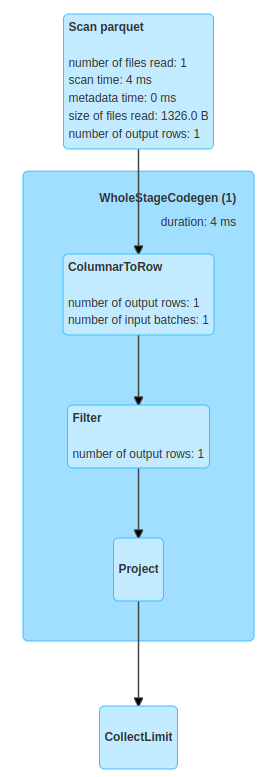

In [63]:
df.filter("action = '?'").show()

+------+----------+------+-------+
|action|      date|device|user_id|
+------+----------+------+-------+
|     ?|2021-04-11|     2|     -1|
+------+----------+------+-------+



In [64]:
spark.stop()

### Others sources: 

- [deletes, updates and merges](https://docs.delta.io/latest/delta-update.html#table-deletes-updates-and-merges)
- [best practices](https://docs.delta.io/latest/best-practices.html#best-practices)
- [Python documentation](https://docs.delta.io/latest/api/python/index.html)